#### This model performs sentiment classification  of review in Amazon, Yelp and IMDB. 

The purposes of this modelling are:
1. Exploring features and algorithms that superior in discriminating negative and positive review
2. Understanding what words that represent negative or positive review. This understanding can provide insight about features that make customer satisfied or disappointed.  

Dataset is downloaded from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [67]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import itertools
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


def transform_into_tfidf(x_train, x_test, bigram=False):
    if(bigram): 
        ngram_range=(1, 2) #this is includes unigram and bigram
    else:
        ngram_range=(1, 1) #only unigram 
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english', ngram_range=ngram_range)
    x_train_ = vectorizer.fit_transform(x_train)
    x_test_ = vectorizer.transform(x_test)
    feature_names = vectorizer.get_feature_names()
    return x_train_, x_test_, feature_names

def select_k_best_features(X_train, y_train, X_test, k=1000):
    #choose k most discriminatif word between classes
    ch2 = SelectKBest(chi2, k=k)
    X_train_ = ch2.fit_transform(X_train, y_train)
    X_test_ = ch2.transform(X_test)
    selected_index = ch2.get_support(indices=True)
    return X_train_, X_test_, selected_index

def benchmark_scikitlearn_classifiers(X_train, y_train, X_test, y_test):
    X_train = np.asarray(x_train.todense())
    X_test = np.asarray(x_test.todense())
    
    models = [RidgeClassifier(tol=1e-2, solver="lsqr"),RandomForestClassifier(n_estimators=50),
        PassiveAggressiveClassifier(n_iter=50), KNeighborsClassifier(n_neighbors=1), GradientBoostingClassifier()]
    
    models_name = ['Ridge Classifier', 'Random Forest', 'Passive Aggressive Classifier', 'k Nearest Neighbour', 'Gradient Boosting Classifier']
    for i,model in enumerate(models):
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        print(models_name[i]+' accuracy:', accuracy_score(y_test, predicted))
        print(classification_report(y_test, predicted))

def mlp_tensorflow_classifiers(X_train, y_train, X_test, y_test):
    X_train_ = np.asarray(X_train.todense())
    X_test_ = np.asarray(X_test.todense())
    
    #one layer neural network
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_.shape[1], activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    
    model.fit(X_train_, y_train, epochs=10, batch_size=32)
    
    score = model.evaluate(X_test_, y_test, batch_size=32)
    print(score)
    
def load_and_prepare_dataset(file_name):
    regex = re.compile('[^a-zA-Z]') #take words only
    data = []
    labels = [] #0:negative, 1:positive
    with open(file_name) as f:
        for l in f.readlines():
            if len(l.strip())>0:
                ls = l.split('\t')
                labels.append(int(ls[1].strip()))
                data.append(regex.sub(' ',ls[0]))
    
    return train_test_split(data, labels, test_size=0.1, random_state=123)

def visualize_important_words(vis_sample, selected_word):
    plt.figure(figsize=(11,8))
    plt.imshow(vis_sample, cmap=plt.cm.Blues, interpolation='nearest')
    tick_marks_x = np.arange(len(selected_word))
    plt.xticks(tick_marks_x, selected_word, rotation=80)
    label_y = ['neg','neg','neg','neg','neg','pos','pos','pos','pos','pos']
    tick_marks_y =np.arange(len(label_y))
    plt.yticks(tick_marks_y, label_y)
    cax = plt.axes([1, 0.1, 0.05, 0.65])
    plt.colorbar(cax=cax)
    plt.show()

# Sentiment classification of Amazon cellphone review

### Load data & labels, then split into training and testing set

In [19]:
file_name='./data/sentiment labelled sentences/amazon_cells_labelled.txt'
X_train_str, X_test_str, y_train, y_test = load_and_prepare_dataset(file_name)

## Case 1: unigram feature

### Transform into Tf-idf and select k most discriminatif features

In [20]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)

### Benchmarking using scikit-learn classifiers

In [21]:
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.81
             precision    recall  f1-score   support

          0       0.81      0.83      0.82        52
          1       0.81      0.79      0.80        48

avg / total       0.81      0.81      0.81       100

Random Forest accuracy: 0.84
             precision    recall  f1-score   support

          0       0.79      0.94      0.86        52
          1       0.92      0.73      0.81        48

avg / total       0.85      0.84      0.84       100



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Passive Aggressive Classifier accuracy: 0.78
             precision    recall  f1-score   support

          0       0.75      0.87      0.80        52
          1       0.82      0.69      0.75        48

avg / total       0.79      0.78      0.78       100

k Nearest Neighbour accuracy: 0.74
             precision    recall  f1-score   support

          0       0.78      0.69      0.73        52
          1       0.70      0.79      0.75        48

avg / total       0.74      0.74      0.74       100

Gradient Boosting Classifier accuracy: 0.82
             precision    recall  f1-score   support

          0       0.75      0.98      0.85        52
          1       0.97      0.65      0.78        48

avg / total       0.85      0.82      0.81       100



### Classification using MLP tensorflow

In [218]:
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Epoch 1/10
900/900 [==============================] - 2s 3ms/step - loss: 0.6909 - acc: 0.5344
Epoch 2/10
900/900 [==============================] - 0s 270us/step - loss: 0.6790 - acc: 0.6189
Epoch 3/10
900/900 [==============================] - 0s 267us/step - loss: 0.6472 - acc: 0.7222
Epoch 4/10
900/900 [==============================] - 0s 270us/step - loss: 0.5822 - acc: 0.8078
Epoch 5/10
900/900 [==============================] - 0s 267us/step - loss: 0.4904 - acc: 0.8433
Epoch 6/10
900/900 [==============================] - 0s 270us/step - loss: 0.4037 - acc: 0.8589
Epoch 7/10
900/900 [==============================] - 0s 299us/step - loss: 0.3326 - acc: 0.8878
Epoch 8/10
900/900 [==============================] - 0s 254us/step - loss: 0.2756 - acc: 0.9067
Epoch 9/10
900/900 [==============================] - 0s 270us/step - loss: 0.2228 - acc: 0.9322
Epoch 10/10
100/100 [==============================] - 1s 6ms/step
[0.34486423969268798, 0.82999999999999996]


## Case 2 : Unigram and Bigram features

### Transform into Tf-idf and select k most discriminatif features
    

In [219]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)

### Benchmarking using scikit-learn classifiers

In [220]:
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.86
             precision    recall  f1-score   support

          0       0.85      0.88      0.87        52
          1       0.87      0.83      0.85        48

avg / total       0.86      0.86      0.86       100

Random Forest accuracy: 0.85
             precision    recall  f1-score   support

          0       0.80      0.94      0.87        52
          1       0.92      0.75      0.83        48

avg / total       0.86      0.85      0.85       100

Passive Aggressive Classifier accuracy: 0.79
             precision    recall  f1-score   support

          0       0.83      0.75      0.79        52
          1       0.75      0.83      0.79        48

avg / total       0.79      0.79      0.79       100

k Nearest Neighbour accuracy: 0.72
             precision    recall  f1-score   support

          0       0.73      0.73      0.73        52
          1       0.71      0.71      0.71        48

avg / total       0.72      0.72      0.72       100


### Classification using MLP tensorflow

In [223]:
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Epoch 1/10
900/900 [==============================] - 1s 1ms/step - loss: 0.6914 - acc: 0.5244
Epoch 2/10
900/900 [==============================] - 0s 282us/step - loss: 0.6803 - acc: 0.6311
Epoch 3/10
900/900 [==============================] - 0s 259us/step - loss: 0.6566 - acc: 0.7278
Epoch 4/10
900/900 [==============================] - 0s 243us/step - loss: 0.6113 - acc: 0.7778
Epoch 5/10
900/900 [==============================] - 0s 241us/step - loss: 0.5371 - acc: 0.8300
Epoch 6/10
900/900 [==============================] - 0s 258us/step - loss: 0.4472 - acc: 0.8567
Epoch 7/10
900/900 [==============================] - 0s 261us/step - loss: 0.3660 - acc: 0.8856
Epoch 8/10
900/900 [==============================] - 0s 277us/step - loss: 0.3080 - acc: 0.8989
Epoch 9/10
900/900 [==============================] - 0s 370us/step - loss: 0.2584 - acc: 0.9122
Epoch 10/10
100/100 [==============================] - 0s 4ms/step
[0.38277961254119874, 0.80000000000000004]


## Visualisation

In this visualisation, in order to be read easily, fifteen only features will be selected. Each negative and positive samples are chosen to be visualised.

['bad', 'disappointed', 'excellent', 'good', 'great', 'great phone', 'love', 'money', 'nice', 'poor', 'price', 'waste', 'works', 'works great', 'worst']


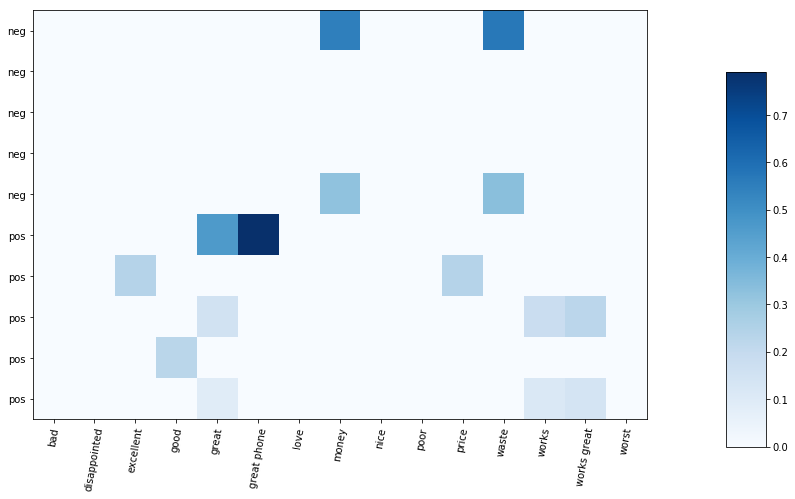

In [36]:
index_neg=[2,10,13,21,66] #sample index for negative sentiment
index_pos = [4,35,43,63,76] #sample index for positive sentiment
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test, k=15)

selected_word = [feature_names[i] for i in selected_index]
print(selected_word)

#choose the negative and positive samples that will be visualised
vis_sample = np.ndarray(shape=(10,15))
vis_sample[0:5] = x_train_sel[index_neg].todense()
vis_sample[5:] = x_train_sel[index_pos].todense()

#plot to heatmap
visualize_important_words(vis_sample, selected_word)

### Notes:

1. The fifteen most discriminatif features are : 'bad', 'disappointed', 'excellent', 'good', 'great', 'great phone', 'love', 'money', 'nice', 'poor', 'price', 'waste', 'works', 'works great', 'worst'.

2. According to random negative samples, the negative sentiment reviews have high tf-idf value for : 'money' and 'waste'. Possibly, the review is negative because of the cell phone is too expensive

3. According to random positive samples, the positive sentiment reviews have high tf-idf value for : 'excellent', 'good', 'great', 'great phone', 'price', 'works', 'works great'. The possible guess is consumer happy with the function of the cell phone (it works great) and the price is worthy (form the word 'price')

4. Compare to unigram only, the classifiers perform better when using unigram and bigram features.

6. According to the classifier benchmarking, when using unigram (one word) as feature, tensorflow MLP achieve the highest accuracy, around 83%

7. When using bigram feature (one to two words), Ridge Classifier perform the highest accuracy (around 86%) compare to other examined scikit-learn clssifiers. In this scenario, accuracy of tensorflow MLP lower than Ridge Classifier. The possible justification is because the model tend to overfit. However, this problem might be tackled by parameter tuning.


# Sentiment classification of Yelp review

In [37]:
# Load data & labels, then split into training and testing set

file_name='./data/sentiment labelled sentences/yelp_labelled.txt'
X_train_str, X_test_str, y_train, y_test = load_and_prepare_dataset(file_name)

## Benchmarking

## Case 1: unigram feature

In [38]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.81
             precision    recall  f1-score   support

          0       0.81      0.76      0.78        45
          1       0.81      0.85      0.83        55

avg / total       0.81      0.81      0.81       100

Random Forest accuracy: 0.77
             precision    recall  f1-score   support

          0       0.72      0.80      0.76        45
          1       0.82      0.75      0.78        55

avg / total       0.78      0.77      0.77       100



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Passive Aggressive Classifier accuracy: 0.71
             precision    recall  f1-score   support

          0       0.74      0.56      0.63        45
          1       0.70      0.84      0.76        55

avg / total       0.71      0.71      0.70       100

k Nearest Neighbour accuracy: 0.65
             precision    recall  f1-score   support

          0       0.60      0.64      0.62        45
          1       0.69      0.65      0.67        55

avg / total       0.65      0.65      0.65       100

Gradient Boosting Classifier accuracy: 0.81
             precision    recall  f1-score   support

          0       0.74      0.89      0.81        45
          1       0.89      0.75      0.81        55

avg / total       0.82      0.81      0.81       100

Epoch 1/10
900/900 [==============================] - 1s 798us/step - loss: 0.6897 - acc: 0.5556
Epoch 2/10
900/900 [==============================] - 0s 308us/step - loss: 0.6616 - acc: 0.7056
Epoch 3/10
900/900 [=================

## Case 2: unigram and bigram feature

In [39]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.82
             precision    recall  f1-score   support

          0       0.83      0.76      0.79        45
          1       0.81      0.87      0.84        55

avg / total       0.82      0.82      0.82       100

Random Forest accuracy: 0.77
             precision    recall  f1-score   support

          0       0.73      0.78      0.75        45
          1       0.81      0.76      0.79        55

avg / total       0.77      0.77      0.77       100



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Passive Aggressive Classifier accuracy: 0.75
             precision    recall  f1-score   support

          0       0.76      0.64      0.70        45
          1       0.74      0.84      0.79        55

avg / total       0.75      0.75      0.75       100

k Nearest Neighbour accuracy: 0.61
             precision    recall  f1-score   support

          0       0.57      0.58      0.57        45
          1       0.65      0.64      0.64        55

avg / total       0.61      0.61      0.61       100

Gradient Boosting Classifier accuracy: 0.78
             precision    recall  f1-score   support

          0       0.72      0.84      0.78        45
          1       0.85      0.73      0.78        55

avg / total       0.79      0.78      0.78       100

Epoch 1/10
900/900 [==============================] - 1s 585us/step - loss: 0.6882 - acc: 0.5444
Epoch 2/10
900/900 [==============================] - 0s 307us/step - loss: 0.6674 - acc: 0.7178
Epoch 3/10
900/900 [=================

## Visualization

['amazing', 'awesome', 'bad', 'delicious', 'don', 'fantastic', 'friendly', 'good', 'great', 'minutes', 'nice', 'probably', 'terrible', 'won', 'worst']


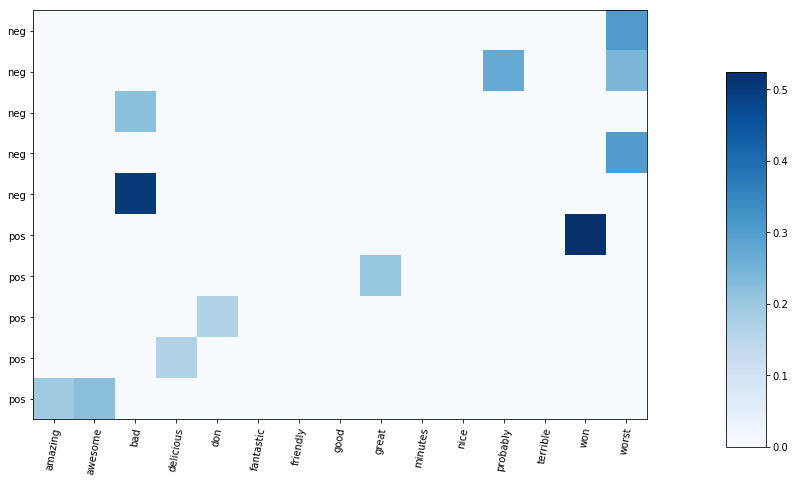

In [51]:
index_neg=[85,94,182,280,764] #sample index for negative sentiment
index_pos = [1,2,5,18,187] #sample index for positive sentiment
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test, k=15)

selected_word = [feature_names[i] for i in selected_index]
print(selected_word)

#choose the negative and positive samples that will be visualised
vis_sample = np.ndarray(shape=(10,15))
vis_sample[0:5] = x_train_sel[index_neg].todense()
vis_sample[5:] = x_train_sel[index_pos].todense()

#plot to heatmap
visualize_important_words(vis_sample, selected_word)

# Sentiment classification of IMDB review

In [52]:
# Load data & labels, then split into training and testing set

file_name='./data/sentiment labelled sentences/imdb_labelled.txt'
X_train_str, X_test_str, y_train, y_test = load_and_prepare_dataset(file_name)

## Benchmarking

## Case 1: unigram feature

In [53]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.76
             precision    recall  f1-score   support

          0       0.78      0.71      0.74        49
          1       0.75      0.80      0.77        51

avg / total       0.76      0.76      0.76       100

Random Forest accuracy: 0.72
             precision    recall  f1-score   support

          0       0.78      0.59      0.67        49
          1       0.68      0.84      0.75        51

avg / total       0.73      0.72      0.72       100



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Passive Aggressive Classifier accuracy: 0.76
             precision    recall  f1-score   support

          0       0.76      0.76      0.76        49
          1       0.76      0.76      0.76        51

avg / total       0.76      0.76      0.76       100

k Nearest Neighbour accuracy: 0.54
             precision    recall  f1-score   support

          0       0.62      0.16      0.26        49
          1       0.53      0.90      0.67        51

avg / total       0.57      0.54      0.47       100

Gradient Boosting Classifier accuracy: 0.73
             precision    recall  f1-score   support

          0       0.68      0.84      0.75        49
          1       0.80      0.63      0.70        51

avg / total       0.74      0.73      0.73       100

Epoch 1/10
900/900 [==============================] - 1s 605us/step - loss: 0.6897 - acc: 0.5333
Epoch 2/10
900/900 [==============================] - 0s 324us/step - loss: 0.6685 - acc: 0.6911
Epoch 3/10
900/900 [=================

## Case 2: unigram and bigram feature

In [54]:
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test)
benchmark_scikitlearn_classifiers(x_train_sel, y_train, x_test_sel, y_test)
mlp_tensorflow_classifiers(x_train_sel, y_train, x_test_sel, y_test)

Ridge Classifier accuracy: 0.77
             precision    recall  f1-score   support

          0       0.80      0.71      0.75        49
          1       0.75      0.82      0.79        51

avg / total       0.77      0.77      0.77       100

Random Forest accuracy: 0.68
             precision    recall  f1-score   support

          0       0.70      0.61      0.65        49
          1       0.67      0.75      0.70        51

avg / total       0.68      0.68      0.68       100



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Passive Aggressive Classifier accuracy: 0.77
             precision    recall  f1-score   support

          0       0.78      0.73      0.76        49
          1       0.76      0.80      0.78        51

avg / total       0.77      0.77      0.77       100

k Nearest Neighbour accuracy: 0.55
             precision    recall  f1-score   support

          0       0.83      0.10      0.18        49
          1       0.53      0.98      0.69        51

avg / total       0.68      0.55      0.44       100

Gradient Boosting Classifier accuracy: 0.75
             precision    recall  f1-score   support

          0       0.70      0.86      0.77        49
          1       0.82      0.65      0.73        51

avg / total       0.76      0.75      0.75       100

Epoch 1/10
900/900 [==============================] - 0s 517us/step - loss: 0.6911 - acc: 0.5367
Epoch 2/10
900/900 [==============================] - 0s 278us/step - loss: 0.6777 - acc: 0.5944
Epoch 3/10
900/900 [=================

## Visualization

['avoid', 'awful', 'bad', 'boring', 'enjoyed', 'excellent', 'funny', 'great', 'liked', 'love', 'plot', 'stupid', 'sucked', 'waste time', 'wonderful']


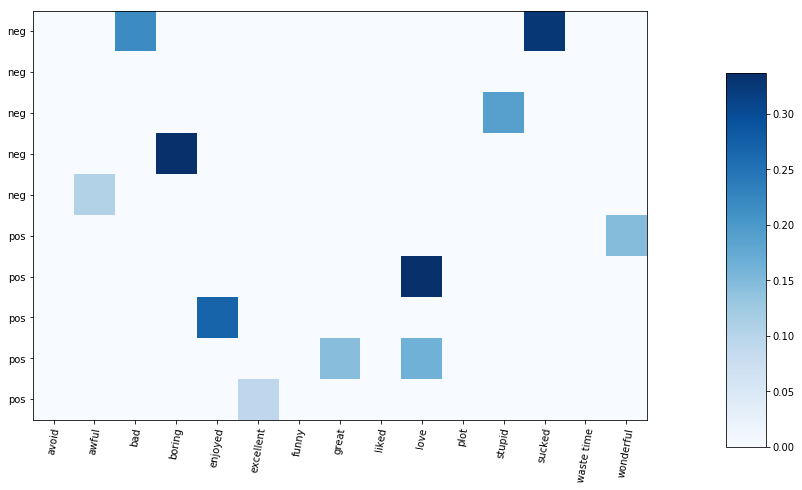

In [66]:
index_neg=[15,16,84,283,294] #sample index for negative sentiment
index_pos = [5,49,65,69,184] #sample index for positive sentiment
x_train, x_test, feature_names = transform_into_tfidf(X_train_str, X_test_str, True)
x_train_sel, x_test_sel, selected_index = select_k_best_features(x_train, y_train, x_test, k=15)

selected_word = [feature_names[i] for i in selected_index]
print(selected_word)

#choose the negative and positive samples that will be visualised
vis_sample = np.ndarray(shape=(10,15))
vis_sample[0:5] = x_train_sel[index_neg].todense()
vis_sample[5:] = x_train_sel[index_pos].todense()

#plot to heatmap
visualize_important_words(vis_sample, selected_word)